# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

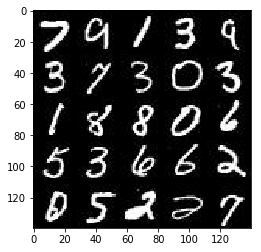

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

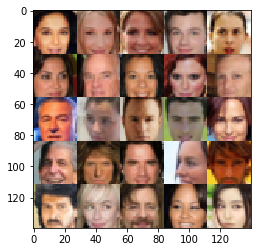

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, 
                        shape=(None, image_width, image_height,  image_channels), 
                        name="input_real")
    
    input_z = tf.placeholder(tf.float32,
                      shape=(None, z_dim),
                      name="input_z")
    
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, debug=True):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope("discriminator", reuse=reuse):
        alpha = 0.1
        
        # First layer, goes from 28x28x3 to 14x14x64, no batch normalization
        # TODO MORIANO ==> Should the activation function be = NONE ?????
        layer_1 = tf.layers.conv2d(images, 
                                      64, #Output channels
                                      5, # Kernel
                                      strides=2,
                                      padding='same',
                                     )
        layer_1 = tf.maximum(layer_1, layer_1 * alpha)
        
        # Second layer, goes from 14x14x64 to 7x7x128
        layer_2 = tf.layers.conv2d(layer_1,
                                       128,
                                       5,
                                       strides=2,
                                       padding='same')
        layer_2 = tf.layers.batch_normalization(layer_2, training=True)
        layer_2 = tf.maximum(layer_2, layer_2 * alpha)
        
        # Third layer, goes from 7x7x128 to 3x3x256
        layer_3 = tf.layers.conv2d(layer_2,
                                       256,
                                       5,
                                       strides=2,
                                       padding='same')
        layer_3 = tf.layers.batch_normalization(layer_3, training=True)
        layer_3 = tf.maximum(layer_3, layer_3 * alpha)
        
        
        
        # Flatten now
        output_layer = tf.reshape(layer_3, (-1, 4*4*256))
        logits = tf.layers.dense(output_layer, 1)
        output = tf.sigmoid(logits)
        
        if debug:
            print("----------------------------------------")
            print("DISCRIMINATOR STARTS")
            print("X", images.shape)
            print("layer_1", layer_1.shape)
            print("layer_2", layer_2.shape)
            print("layer_3", layer_3.shape)
            print("logits", logits.shape)
            print("DISCRIMINATOR ENDS")
            print("----------------------------------------\n")
        
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

----------------------------------------
DISCRIMINATOR STARTS
X (?, 28, 28, 3)
layer_1 (?, 14, 14, 64)
layer_2 (?, 7, 7, 128)
layer_3 (?, 4, 4, 256)
logits (?, 1)
DISCRIMINATOR ENDS
----------------------------------------

----------------------------------------
DISCRIMINATOR STARTS
X (?, 28, 28, 3)
layer_1 (?, 14, 14, 64)
layer_2 (?, 7, 7, 128)
layer_3 (?, 4, 4, 256)
logits (?, 1)
DISCRIMINATOR ENDS
----------------------------------------

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [13]:
def generator(z, out_channel_dim, is_train=True, debug=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    

    print("-----")
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse=not is_train):
        alpha = 0.1
        layer_1 = tf.layers.dense(z, 7 * 7 * 512)
        
        layer_1 = tf.reshape(layer_1, (-1, 7, 7, 512))
        layer_1 = tf.layers.batch_normalization(layer_1, training=is_train)
        
        layer_1 = tf.maximum(layer_1, layer_1 * alpha) # TODO MORIANO not sure about this
        
        # Second layer, go from 7x7x128 to 14x14x64
        layer_2 = tf.layers.conv2d_transpose(layer_1, 
                                                  256,
                                                  5,
                                                  strides=2,
                                                  padding="same")
        layer_2 = tf.layers.batch_normalization(layer_2, training=is_train)
        layer_2 = tf.maximum(layer_2, layer_2 * alpha)
        
        # Third layer
        layer_3 = tf.layers.conv2d_transpose(layer_2, 
                                                  128,
                                                  5,
                                                  strides=2,
                                                  padding="same")
        layer_3 = tf.layers.batch_normalization(layer_3, training=is_train)
        layer_3 = tf.maximum(layer_3, layer_3 * alpha)
        
        
        # Third layer, go from 14x14x64 to 28x28xout_channel_dim
        logits = tf.layers.conv2d_transpose(layer_3,
                                                out_channel_dim,
                                                5,
                                                strides=1,
                                                padding="same")
        logits = tf.maximum(logits, logits*alpha)
        
        # Output layer
        
        if debug:
            print("---------------------")
            print("GENERATOR STARTS")
            print("Z", z.shape)
            print("layer_1 =>", layer_1.shape)
            print("layer_2 =>", layer_2.shape)
            print("layer_3 =>", layer_3.shape)
            print("logits", logits.shape)
            print("GENERATOR ENDS")
            print("---------------------\n")
        
        output = tf.tanh(logits)
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

-----
---------------------
GENERATOR STARTS
Z (?, 100)
layer_1 => (?, 7, 7, 512)
layer_2 => (?, 14, 14, 256)
layer_3 => (?, 28, 28, 128)
logits (?, 28, 28, 5)
GENERATOR ENDS
---------------------

-----
---------------------
GENERATOR STARTS
Z (?, 100)
layer_1 => (?, 7, 7, 512)
layer_2 => (?, 14, 14, 256)
layer_3 => (?, 28, 28, 128)
logits (?, 28, 28, 5)
GENERATOR ENDS
---------------------

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [14]:
def model_loss(input_real, input_z, out_channel_dim, debug=True):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, debug=debug)
    d_model_real, d_logits_real = discriminator(input_real, debug=debug)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, debug=debug)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

    
    
    if debug:
        print("----------------------\nmodel_loss()")
        print("OUT CHANNEL DIM ==>", out_channel_dim)
        print("Generator =>", g_model.shape)
        print("Discriminator (real)", d_model_real.shape)
        print("Discriminator (fake)", d_model_fake.shape)
        print("discriminator_logits_fake", d_logits_fake.shape)
        print("discriminator_loss_real", d_loss_real.shape)
        print("discriminator_loss_fake", d_loss_fake.shape)
        print("----------------------\n ")
    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

-----
---------------------
GENERATOR STARTS
Z (?, 100)
layer_1 => (?, 7, 7, 512)
layer_2 => (?, 14, 14, 256)
layer_3 => (?, 28, 28, 128)
logits (?, 28, 28, 4)
GENERATOR ENDS
---------------------

----------------------------------------
DISCRIMINATOR STARTS
X (?, 28, 28, 4)
layer_1 (?, 14, 14, 64)
layer_2 (?, 7, 7, 128)
layer_3 (?, 4, 4, 256)
logits (?, 1)
DISCRIMINATOR ENDS
----------------------------------------

----------------------------------------
DISCRIMINATOR STARTS
X (?, 28, 28, 4)
layer_1 (?, 14, 14, 64)
layer_2 (?, 7, 7, 128)
layer_3 (?, 4, 4, 256)
logits (?, 1)
DISCRIMINATOR ENDS
----------------------------------------

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [15]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # This seems to be pretty much the same as in the MNIST gan...
     # Get weights and bias to update
    t_vars = tf.trainable_variables()


    discriminator_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    generator_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, 
                                                         beta1=beta1).minimize(d_loss, 
                                                                                var_list=discriminator_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, 
                                                     beta1=beta1).minimize(g_loss, 
                                                                           var_list=generator_vars)

    return d_train_opt, g_train_opt
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False, debug=False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
def train(epoch_count, batch_size, z_dim, my_learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print(data_shape)
    image_width, image_height, image_channels = data_shape[1], data_shape[2], data_shape[3]
    
    input_real, input_z, learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    discriminator_loss, generator_loss = model_loss(input_real, input_z, image_channels, debug=False)
    
    discriminator_opt, generator_opt = model_opt(discriminator_loss, generator_loss, learning_rate, beta1)
    
    
    print(image_width, "x", image_height, "x", image_channels)
    with tf.Session() as sess:
        print("In session")
        sess.run(tf.global_variables_initializer())
        print("Session initialized")
        for epoch_i in range(epoch_count):
            print("Epoch", epoch_i)
            batch_no = 0
            for batch_images in get_batches(batch_size):
                
                # Run optimizers
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                
                sess.run(generator_opt, feed_dict={input_z: batch_z,
                                                   input_real: batch_images,
                                                      learning_rate: my_learning_rate})
                sess.run(discriminator_opt, feed_dict={input_z: batch_z, 
                                                       input_real: batch_images,
                                                      learning_rate: my_learning_rate}) 
                
                if batch_no % 10 == 0:
                    train_loss_d = discriminator_loss.eval({input_z: batch_z, 
                                                            input_real: batch_images})
                    train_loss_g = generator_loss.eval({input_z: batch_z})
                    
                    print("Epoch %d , batch %d, dloss = %.4f gloss = %.4f" % (epoch_i, 
                                                                              batch_no, 
                                                                              train_loss_d,
                                                                             train_loss_g))

                
                if batch_no % 100 == 0:
                    images_to_show = 25
                    show_generator_output(sess, 
                                          images_to_show, 
                                          input_z,
                                          image_channels, 
                                          data_image_mode)
                
                
                batch_no += 1


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
-----
28 x 28 x 1
In session
Session initialized
Epoch 0
Epoch 0 , batch 0, dloss = 0.3835 gloss = 3.9324
-----


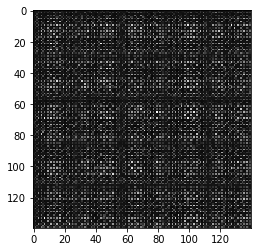

Epoch 0 , batch 10, dloss = 0.3380 gloss = 6.8265
Epoch 0 , batch 20, dloss = 0.3455 gloss = 5.6713
Epoch 0 , batch 30, dloss = 0.4323 gloss = 5.5439
Epoch 0 , batch 40, dloss = 0.3478 gloss = 5.5623
Epoch 0 , batch 50, dloss = 0.3881 gloss = 6.2429
Epoch 0 , batch 60, dloss = 0.3838 gloss = 4.0959
Epoch 0 , batch 70, dloss = 0.4618 gloss = 2.8035
Epoch 0 , batch 80, dloss = 0.6773 gloss = 3.5779
Epoch 0 , batch 90, dloss = 0.5679 gloss = 2.2926
Epoch 0 , batch 100, dloss = 0.8502 gloss = 3.0337
-----


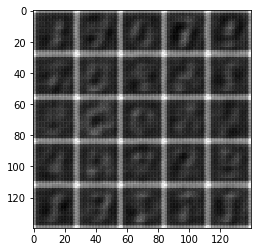

Epoch 0 , batch 110, dloss = 0.8565 gloss = 1.1335
Epoch 0 , batch 120, dloss = 0.6418 gloss = 1.9617
Epoch 0 , batch 130, dloss = 0.7243 gloss = 1.6892
Epoch 0 , batch 140, dloss = 0.6885 gloss = 2.2741
Epoch 0 , batch 150, dloss = 1.2098 gloss = 3.8330
Epoch 0 , batch 160, dloss = 0.6962 gloss = 1.3977
Epoch 0 , batch 170, dloss = 1.1320 gloss = 0.7087
Epoch 0 , batch 180, dloss = 0.9307 gloss = 2.9363
Epoch 0 , batch 190, dloss = 0.7275 gloss = 1.5589
Epoch 0 , batch 200, dloss = 0.8309 gloss = 1.1201
-----


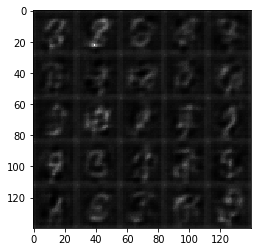

Epoch 0 , batch 210, dloss = 0.6961 gloss = 2.4416
Epoch 0 , batch 220, dloss = 1.8307 gloss = 4.7312
Epoch 0 , batch 230, dloss = 0.8972 gloss = 1.0069
Epoch 0 , batch 240, dloss = 0.6664 gloss = 1.4903
Epoch 0 , batch 250, dloss = 0.6796 gloss = 2.1021
Epoch 0 , batch 260, dloss = 0.7100 gloss = 2.6282
Epoch 0 , batch 270, dloss = 0.8447 gloss = 1.2300
Epoch 0 , batch 280, dloss = 0.6756 gloss = 1.5120
Epoch 0 , batch 290, dloss = 0.6070 gloss = 1.9714
Epoch 0 , batch 300, dloss = 0.7684 gloss = 2.6979
-----


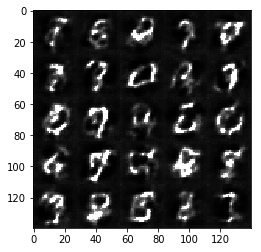

Epoch 0 , batch 310, dloss = 0.9499 gloss = 0.9574
Epoch 0 , batch 320, dloss = 1.2165 gloss = 3.8795
Epoch 0 , batch 330, dloss = 0.7337 gloss = 2.4833
Epoch 0 , batch 340, dloss = 0.7436 gloss = 2.7817
Epoch 0 , batch 350, dloss = 0.6731 gloss = 1.7228
Epoch 0 , batch 360, dloss = 0.7187 gloss = 2.3243
Epoch 0 , batch 370, dloss = 0.8561 gloss = 1.1584
Epoch 0 , batch 380, dloss = 1.0904 gloss = 3.4475
Epoch 0 , batch 390, dloss = 0.6494 gloss = 1.6066
Epoch 0 , batch 400, dloss = 0.6570 gloss = 2.1462
-----


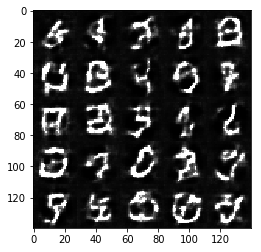

Epoch 0 , batch 410, dloss = 0.8205 gloss = 1.1482
Epoch 0 , batch 420, dloss = 0.6710 gloss = 2.0596
Epoch 0 , batch 430, dloss = 0.8240 gloss = 1.1089
Epoch 0 , batch 440, dloss = 1.2149 gloss = 0.7550
Epoch 0 , batch 450, dloss = 0.7419 gloss = 2.2073
Epoch 0 , batch 460, dloss = 0.7211 gloss = 1.3114
Epoch 0 , batch 470, dloss = 0.9546 gloss = 0.9872
Epoch 0 , batch 480, dloss = 0.6607 gloss = 1.8596
Epoch 0 , batch 490, dloss = 0.6576 gloss = 1.5695
Epoch 0 , batch 500, dloss = 1.0995 gloss = 0.7859
-----


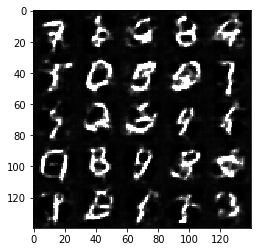

Epoch 0 , batch 510, dloss = 0.7902 gloss = 2.5634
Epoch 0 , batch 520, dloss = 0.8297 gloss = 1.1230
Epoch 0 , batch 530, dloss = 0.7862 gloss = 2.2563
Epoch 0 , batch 540, dloss = 0.6862 gloss = 1.6991
Epoch 0 , batch 550, dloss = 0.9612 gloss = 3.0268
Epoch 0 , batch 560, dloss = 0.9860 gloss = 3.1689
Epoch 0 , batch 570, dloss = 0.6559 gloss = 2.2278
Epoch 0 , batch 580, dloss = 0.7728 gloss = 2.9771
Epoch 0 , batch 590, dloss = 0.9602 gloss = 2.6160
Epoch 0 , batch 600, dloss = 0.9706 gloss = 0.9327
-----


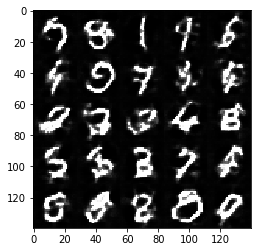

Epoch 0 , batch 610, dloss = 0.6683 gloss = 2.0593
Epoch 0 , batch 620, dloss = 0.7227 gloss = 1.6449
Epoch 0 , batch 630, dloss = 0.7243 gloss = 1.7746
Epoch 0 , batch 640, dloss = 0.7276 gloss = 2.0501
Epoch 0 , batch 650, dloss = 1.0240 gloss = 3.4099
Epoch 0 , batch 660, dloss = 0.6464 gloss = 2.2508
Epoch 0 , batch 670, dloss = 0.7201 gloss = 1.8706
Epoch 0 , batch 680, dloss = 0.7131 gloss = 1.9435
Epoch 0 , batch 690, dloss = 0.8143 gloss = 1.2487
Epoch 0 , batch 700, dloss = 0.8576 gloss = 1.0668
-----


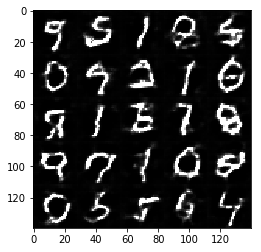

Epoch 0 , batch 710, dloss = 0.9602 gloss = 0.9172
Epoch 0 , batch 720, dloss = 0.6523 gloss = 2.0518
Epoch 0 , batch 730, dloss = 0.6583 gloss = 2.0365
Epoch 0 , batch 740, dloss = 0.6254 gloss = 2.2765
Epoch 0 , batch 750, dloss = 0.9519 gloss = 0.9666
Epoch 0 , batch 760, dloss = 0.7356 gloss = 1.3067
Epoch 0 , batch 770, dloss = 0.6467 gloss = 1.9241
Epoch 0 , batch 780, dloss = 0.7184 gloss = 2.4383
Epoch 0 , batch 790, dloss = 0.9797 gloss = 3.1401
Epoch 0 , batch 800, dloss = 0.6335 gloss = 1.7937
-----


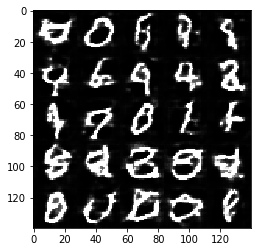

Epoch 0 , batch 810, dloss = 1.0798 gloss = 0.9182
Epoch 0 , batch 820, dloss = 0.5999 gloss = 1.8429
Epoch 0 , batch 830, dloss = 0.9915 gloss = 0.9438
Epoch 0 , batch 840, dloss = 0.6768 gloss = 1.6048
Epoch 0 , batch 850, dloss = 0.7135 gloss = 1.5637
Epoch 0 , batch 860, dloss = 0.7040 gloss = 1.4593
Epoch 0 , batch 870, dloss = 0.6816 gloss = 2.7163
Epoch 0 , batch 880, dloss = 0.7406 gloss = 1.4108
Epoch 0 , batch 890, dloss = 0.7590 gloss = 1.4102
Epoch 0 , batch 900, dloss = 0.6424 gloss = 2.2682
-----


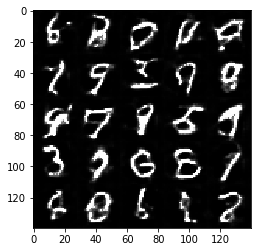

Epoch 0 , batch 910, dloss = 0.8105 gloss = 1.1796
Epoch 0 , batch 920, dloss = 0.7587 gloss = 1.9209
Epoch 0 , batch 930, dloss = 0.6294 gloss = 1.9781
Epoch 1
Epoch 1 , batch 0, dloss = 0.7759 gloss = 3.0154
-----


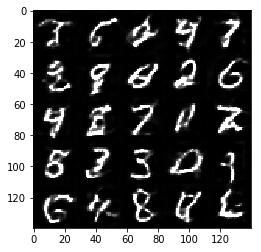

Epoch 1 , batch 10, dloss = 0.7226 gloss = 1.5170
Epoch 1 , batch 20, dloss = 0.8716 gloss = 1.0719
Epoch 1 , batch 30, dloss = 0.6612 gloss = 1.7416
Epoch 1 , batch 40, dloss = 0.6352 gloss = 1.7554
Epoch 1 , batch 50, dloss = 1.0590 gloss = 3.0114
Epoch 1 , batch 60, dloss = 0.6420 gloss = 2.1673
Epoch 1 , batch 70, dloss = 0.6810 gloss = 1.4266
Epoch 1 , batch 80, dloss = 1.1693 gloss = 0.7063
Epoch 1 , batch 90, dloss = 0.6762 gloss = 1.7858
Epoch 1 , batch 100, dloss = 0.7023 gloss = 2.4155
-----


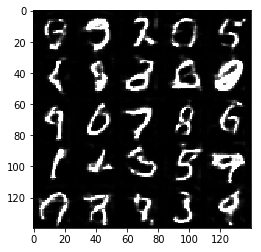

Epoch 1 , batch 110, dloss = 0.6609 gloss = 2.0124
Epoch 1 , batch 120, dloss = 0.6834 gloss = 1.9343
Epoch 1 , batch 130, dloss = 0.7371 gloss = 2.9950
Epoch 1 , batch 140, dloss = 0.7454 gloss = 1.3008
Epoch 1 , batch 150, dloss = 0.7249 gloss = 1.4091
Epoch 1 , batch 160, dloss = 0.7284 gloss = 1.4909
Epoch 1 , batch 170, dloss = 0.6628 gloss = 1.7928
Epoch 1 , batch 180, dloss = 0.8623 gloss = 2.9667
Epoch 1 , batch 190, dloss = 0.9480 gloss = 3.2695
Epoch 1 , batch 200, dloss = 0.8215 gloss = 2.8414
-----


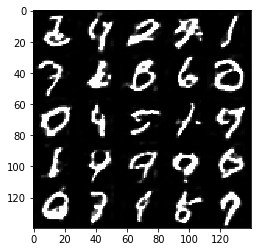

Epoch 1 , batch 210, dloss = 0.8426 gloss = 1.1546
Epoch 1 , batch 220, dloss = 0.6462 gloss = 1.9573
Epoch 1 , batch 230, dloss = 0.6368 gloss = 1.7639
Epoch 1 , batch 240, dloss = 0.5997 gloss = 2.6392
Epoch 1 , batch 250, dloss = 0.6626 gloss = 2.2823
Epoch 1 , batch 260, dloss = 1.1702 gloss = 3.1776
Epoch 1 , batch 270, dloss = 0.6415 gloss = 1.8765
Epoch 1 , batch 280, dloss = 0.6048 gloss = 1.9024
Epoch 1 , batch 290, dloss = 0.7130 gloss = 2.1692
Epoch 1 , batch 300, dloss = 0.7869 gloss = 1.2001
-----


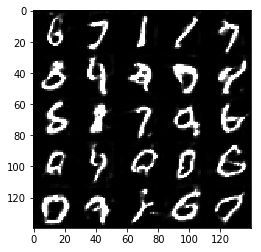

Epoch 1 , batch 310, dloss = 0.7615 gloss = 2.4654
Epoch 1 , batch 320, dloss = 0.7495 gloss = 2.2544
Epoch 1 , batch 330, dloss = 0.6352 gloss = 1.7484
Epoch 1 , batch 340, dloss = 0.6537 gloss = 2.1938
Epoch 1 , batch 350, dloss = 1.7979 gloss = 0.4055
Epoch 1 , batch 360, dloss = 0.6540 gloss = 1.7141
Epoch 1 , batch 370, dloss = 0.6215 gloss = 2.1260
Epoch 1 , batch 380, dloss = 0.6220 gloss = 1.7283
Epoch 1 , batch 390, dloss = 0.7356 gloss = 2.1194
Epoch 1 , batch 400, dloss = 0.7573 gloss = 3.1607
-----


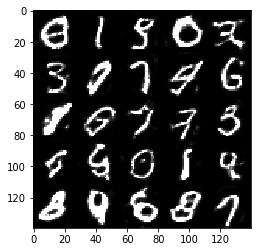

Epoch 1 , batch 410, dloss = 0.9541 gloss = 0.9115
Epoch 1 , batch 420, dloss = 0.5863 gloss = 1.8345
Epoch 1 , batch 430, dloss = 0.6448 gloss = 1.7528
Epoch 1 , batch 440, dloss = 1.8740 gloss = 0.3708
Epoch 1 , batch 450, dloss = 0.6210 gloss = 1.7193
Epoch 1 , batch 460, dloss = 0.6493 gloss = 2.5576
Epoch 1 , batch 470, dloss = 0.6686 gloss = 1.5790
Epoch 1 , batch 480, dloss = 0.7530 gloss = 1.2734
Epoch 1 , batch 490, dloss = 0.6185 gloss = 2.7375
Epoch 1 , batch 500, dloss = 0.9330 gloss = 0.9642
-----


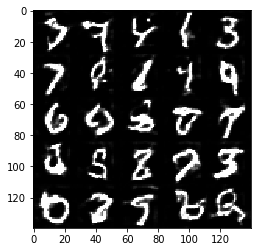

Epoch 1 , batch 510, dloss = 0.7091 gloss = 1.6934
Epoch 1 , batch 520, dloss = 0.6343 gloss = 2.3425
Epoch 1 , batch 530, dloss = 0.6397 gloss = 2.3130
Epoch 1 , batch 540, dloss = 0.7908 gloss = 2.6435
Epoch 1 , batch 550, dloss = 0.6477 gloss = 2.8019
Epoch 1 , batch 560, dloss = 0.6842 gloss = 2.6497
Epoch 1 , batch 570, dloss = 0.5980 gloss = 2.0088
Epoch 1 , batch 580, dloss = 0.6467 gloss = 2.9572
Epoch 1 , batch 590, dloss = 0.7090 gloss = 1.9471
Epoch 1 , batch 600, dloss = 0.5809 gloss = 1.8806
-----


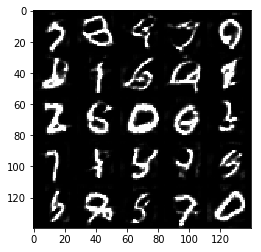

Epoch 1 , batch 610, dloss = 0.6953 gloss = 3.1765
Epoch 1 , batch 620, dloss = 0.6044 gloss = 1.7958
Epoch 1 , batch 630, dloss = 0.9437 gloss = 1.0874
Epoch 1 , batch 640, dloss = 0.6819 gloss = 1.9791
Epoch 1 , batch 650, dloss = 0.5846 gloss = 2.2338
Epoch 1 , batch 660, dloss = 0.5876 gloss = 2.5898
Epoch 1 , batch 670, dloss = 0.6058 gloss = 2.3563
Epoch 1 , batch 680, dloss = 0.5990 gloss = 1.9540
Epoch 1 , batch 690, dloss = 0.6615 gloss = 1.5594
Epoch 1 , batch 700, dloss = 0.5935 gloss = 1.7957
-----


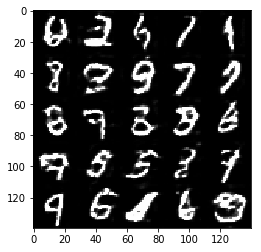

Epoch 1 , batch 710, dloss = 0.6060 gloss = 1.8518
Epoch 1 , batch 720, dloss = 1.0443 gloss = 0.9481
Epoch 1 , batch 730, dloss = 0.5736 gloss = 2.0927
Epoch 1 , batch 740, dloss = 0.6690 gloss = 2.4552
Epoch 1 , batch 750, dloss = 0.6062 gloss = 1.9077
Epoch 1 , batch 760, dloss = 0.5806 gloss = 1.9722
Epoch 1 , batch 770, dloss = 0.7451 gloss = 1.2555
Epoch 1 , batch 780, dloss = 0.6974 gloss = 1.4775
Epoch 1 , batch 790, dloss = 0.8796 gloss = 3.0269
Epoch 1 , batch 800, dloss = 0.6184 gloss = 2.0807
-----


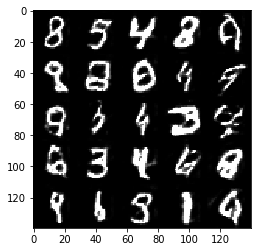

Epoch 1 , batch 810, dloss = 0.8425 gloss = 1.0912
Epoch 1 , batch 820, dloss = 0.5739 gloss = 2.0026
Epoch 1 , batch 830, dloss = 0.7098 gloss = 1.3381
Epoch 1 , batch 840, dloss = 0.7161 gloss = 2.5846
Epoch 1 , batch 850, dloss = 0.7211 gloss = 1.5101
Epoch 1 , batch 860, dloss = 0.5926 gloss = 1.8515
Epoch 1 , batch 870, dloss = 0.6364 gloss = 1.6902
Epoch 1 , batch 880, dloss = 0.6286 gloss = 2.2723
Epoch 1 , batch 890, dloss = 0.6180 gloss = 2.6569
Epoch 1 , batch 900, dloss = 0.6003 gloss = 2.4623
-----


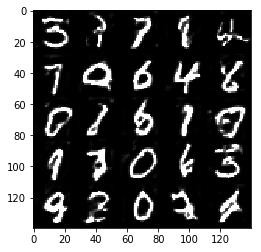

Epoch 1 , batch 910, dloss = 0.7708 gloss = 1.3533
Epoch 1 , batch 920, dloss = 0.8706 gloss = 1.0610
Epoch 1 , batch 930, dloss = 0.5214 gloss = 2.0655
Done!


In [19]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
    
print("Done!")    

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
-----
28 x 28 x 3
In session
Session initialized
Epoch 0
Epoch 0 , batch 0, dloss = 1.0073 gloss = 1.0434
-----


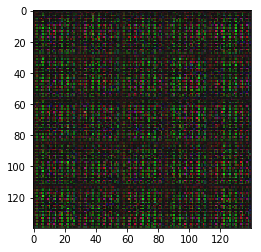

Epoch 0 , batch 10, dloss = 0.3957 gloss = 4.9652
Epoch 0 , batch 20, dloss = 0.3900 gloss = 6.0110
Epoch 0 , batch 30, dloss = 0.3877 gloss = 4.9377
Epoch 0 , batch 40, dloss = 0.4666 gloss = 9.3868
Epoch 0 , batch 50, dloss = 0.4673 gloss = 5.8130
Epoch 0 , batch 60, dloss = 0.8675 gloss = 1.1609
Epoch 0 , batch 70, dloss = 0.5903 gloss = 3.8045
Epoch 0 , batch 80, dloss = 0.7022 gloss = 3.3822
Epoch 0 , batch 90, dloss = 0.6739 gloss = 3.9587
Epoch 0 , batch 100, dloss = 0.8893 gloss = 4.2264
-----


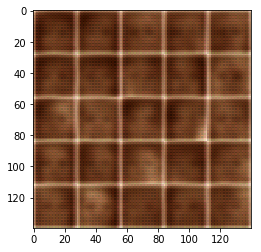

Epoch 0 , batch 110, dloss = 0.6280 gloss = 2.5666
Epoch 0 , batch 120, dloss = 0.5943 gloss = 3.3273
Epoch 0 , batch 130, dloss = 0.7251 gloss = 3.8188
Epoch 0 , batch 140, dloss = 0.6441 gloss = 3.1882
Epoch 0 , batch 150, dloss = 0.5223 gloss = 2.8991
Epoch 0 , batch 160, dloss = 0.6146 gloss = 3.7095
Epoch 0 , batch 170, dloss = 0.6314 gloss = 1.6922
Epoch 0 , batch 180, dloss = 0.9546 gloss = 0.9880
Epoch 0 , batch 190, dloss = 0.4785 gloss = 2.9588
Epoch 0 , batch 200, dloss = 0.9506 gloss = 0.9969
-----


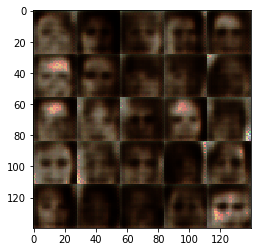

Epoch 0 , batch 210, dloss = 0.4091 gloss = 3.3038
Epoch 0 , batch 220, dloss = 0.5573 gloss = 2.0885
Epoch 0 , batch 230, dloss = 0.5236 gloss = 2.2379
Epoch 0 , batch 240, dloss = 0.4625 gloss = 2.8710
Epoch 0 , batch 250, dloss = 0.5662 gloss = 3.7975
Epoch 0 , batch 260, dloss = 1.1614 gloss = 4.0109
Epoch 0 , batch 270, dloss = 0.5789 gloss = 2.4164
Epoch 0 , batch 280, dloss = 0.5826 gloss = 2.2888
Epoch 0 , batch 290, dloss = 0.6686 gloss = 2.9391
Epoch 0 , batch 300, dloss = 0.5638 gloss = 2.2723
-----


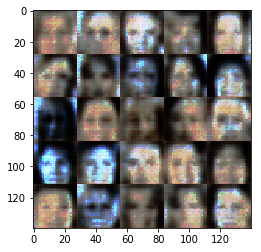

Epoch 0 , batch 310, dloss = 0.8618 gloss = 3.1753
Epoch 0 , batch 320, dloss = 0.5235 gloss = 2.2855
Epoch 0 , batch 330, dloss = 0.6690 gloss = 2.4686
Epoch 0 , batch 340, dloss = 0.6912 gloss = 2.0185
Epoch 0 , batch 350, dloss = 0.9025 gloss = 0.9675
Epoch 0 , batch 360, dloss = 0.6775 gloss = 2.6775
Epoch 0 , batch 370, dloss = 0.6565 gloss = 1.7394
Epoch 0 , batch 380, dloss = 0.6063 gloss = 1.9155
Epoch 0 , batch 390, dloss = 0.8110 gloss = 3.2087
Epoch 0 , batch 400, dloss = 0.6986 gloss = 1.9073
-----


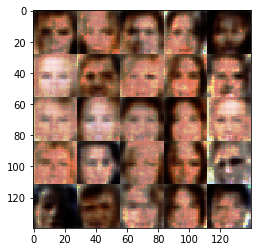

Epoch 0 , batch 410, dloss = 0.7804 gloss = 1.4151
Epoch 0 , batch 420, dloss = 0.9377 gloss = 3.1124
Epoch 0 , batch 430, dloss = 0.7694 gloss = 2.2736
Epoch 0 , batch 440, dloss = 0.7918 gloss = 1.5837
Epoch 0 , batch 450, dloss = 0.9704 gloss = 0.8550
Epoch 0 , batch 460, dloss = 0.7725 gloss = 1.5194
Epoch 0 , batch 470, dloss = 0.7321 gloss = 1.5715
Epoch 0 , batch 480, dloss = 0.8883 gloss = 2.7991
Epoch 0 , batch 490, dloss = 0.8600 gloss = 1.6739
Epoch 0 , batch 500, dloss = 0.9641 gloss = 0.9225
-----


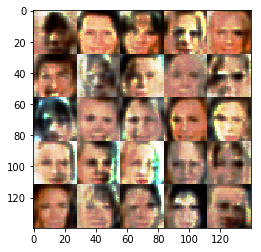

Epoch 0 , batch 510, dloss = 0.9817 gloss = 2.4179
Epoch 0 , batch 520, dloss = 0.7513 gloss = 2.0827
Epoch 0 , batch 530, dloss = 1.0112 gloss = 0.8354
Epoch 0 , batch 540, dloss = 0.7513 gloss = 1.3827
Epoch 0 , batch 550, dloss = 0.9344 gloss = 1.0106
Epoch 0 , batch 560, dloss = 0.8977 gloss = 0.9834
Epoch 0 , batch 570, dloss = 1.0238 gloss = 0.8827
Epoch 0 , batch 580, dloss = 0.8762 gloss = 1.9223
Epoch 0 , batch 590, dloss = 0.7208 gloss = 1.9676
Epoch 0 , batch 600, dloss = 0.7949 gloss = 2.7707
-----


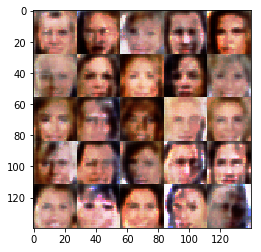

Epoch 0 , batch 610, dloss = 0.7646 gloss = 2.0858
Epoch 0 , batch 620, dloss = 0.8040 gloss = 2.3964
Epoch 0 , batch 630, dloss = 0.8064 gloss = 2.1683
Epoch 0 , batch 640, dloss = 0.7199 gloss = 1.6503
Epoch 0 , batch 650, dloss = 0.7161 gloss = 1.6764
Epoch 0 , batch 660, dloss = 0.9617 gloss = 2.5524
Epoch 0 , batch 670, dloss = 0.7478 gloss = 1.3934
Epoch 0 , batch 680, dloss = 0.8516 gloss = 1.1067
Epoch 0 , batch 690, dloss = 0.7707 gloss = 2.0408
Epoch 0 , batch 700, dloss = 0.9721 gloss = 2.6087
-----


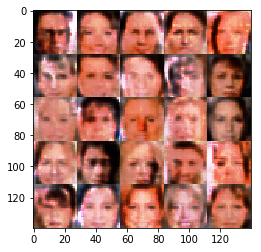

Epoch 0 , batch 710, dloss = 0.8652 gloss = 2.4754
Epoch 0 , batch 720, dloss = 0.6215 gloss = 1.6023
Epoch 0 , batch 730, dloss = 0.7940 gloss = 1.4296
Epoch 0 , batch 740, dloss = 0.8488 gloss = 1.0898
Epoch 0 , batch 750, dloss = 1.0423 gloss = 0.8835
Epoch 0 , batch 760, dloss = 0.8205 gloss = 1.8699
Epoch 0 , batch 770, dloss = 0.8882 gloss = 2.3822
Epoch 0 , batch 780, dloss = 0.8431 gloss = 2.0482
Epoch 0 , batch 790, dloss = 0.9612 gloss = 0.9254
Epoch 0 , batch 800, dloss = 0.8284 gloss = 1.6587
-----


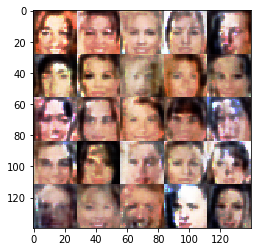

Epoch 0 , batch 810, dloss = 1.1197 gloss = 0.6677
Epoch 0 , batch 820, dloss = 0.7889 gloss = 1.3388
Epoch 0 , batch 830, dloss = 0.8547 gloss = 1.6911
Epoch 0 , batch 840, dloss = 0.9175 gloss = 1.0265
Epoch 0 , batch 850, dloss = 1.6921 gloss = 4.0388
Epoch 0 , batch 860, dloss = 0.8699 gloss = 1.2774
Epoch 0 , batch 870, dloss = 0.8076 gloss = 1.7364
Epoch 0 , batch 880, dloss = 0.9944 gloss = 0.8574
Epoch 0 , batch 890, dloss = 1.0706 gloss = 0.7326
Epoch 0 , batch 900, dloss = 0.7850 gloss = 2.0709
-----


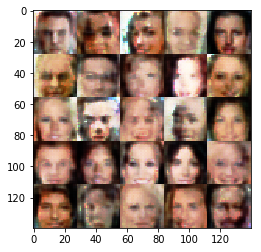

Epoch 0 , batch 910, dloss = 1.2009 gloss = 0.6215
Epoch 0 , batch 920, dloss = 1.1104 gloss = 2.4798
Epoch 0 , batch 930, dloss = 0.9381 gloss = 2.3570
Epoch 0 , batch 940, dloss = 0.8717 gloss = 1.0588
Epoch 0 , batch 950, dloss = 0.7404 gloss = 1.8762
Epoch 0 , batch 960, dloss = 0.9678 gloss = 1.0117
Epoch 0 , batch 970, dloss = 0.8251 gloss = 1.1721
Epoch 0 , batch 980, dloss = 0.7335 gloss = 1.4575
Epoch 0 , batch 990, dloss = 0.8953 gloss = 2.0466
Epoch 0 , batch 1000, dloss = 0.8501 gloss = 1.7929
-----


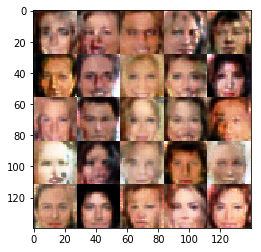

Epoch 0 , batch 1010, dloss = 0.8140 gloss = 2.0381
Epoch 0 , batch 1020, dloss = 0.8926 gloss = 1.0514
Epoch 0 , batch 1030, dloss = 0.9170 gloss = 2.4105
Epoch 0 , batch 1040, dloss = 0.8845 gloss = 1.9517
Epoch 0 , batch 1050, dloss = 0.8078 gloss = 1.3718
Epoch 0 , batch 1060, dloss = 0.7339 gloss = 1.3309
Epoch 0 , batch 1070, dloss = 0.7793 gloss = 1.1487
Epoch 0 , batch 1080, dloss = 0.9911 gloss = 0.8740
Epoch 0 , batch 1090, dloss = 0.7665 gloss = 1.5806
Epoch 0 , batch 1100, dloss = 0.8036 gloss = 1.2020
-----


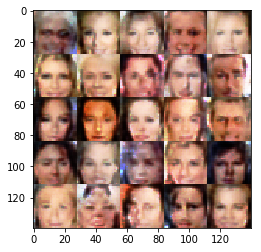

Epoch 0 , batch 1110, dloss = 0.8615 gloss = 1.3159
Epoch 0 , batch 1120, dloss = 0.8309 gloss = 1.1517
Epoch 0 , batch 1130, dloss = 0.8479 gloss = 1.7923
Epoch 0 , batch 1140, dloss = 0.7997 gloss = 1.4087
Epoch 0 , batch 1150, dloss = 0.6882 gloss = 2.1997
Epoch 0 , batch 1160, dloss = 0.8844 gloss = 1.0248
Epoch 0 , batch 1170, dloss = 0.8120 gloss = 1.3228
Epoch 0 , batch 1180, dloss = 0.8058 gloss = 1.2373
Epoch 0 , batch 1190, dloss = 0.8795 gloss = 2.1846
Epoch 0 , batch 1200, dloss = 0.9653 gloss = 0.8574
-----


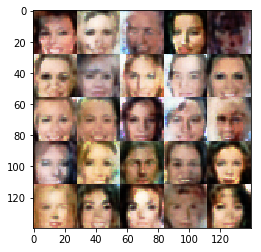

Epoch 0 , batch 1210, dloss = 0.7616 gloss = 1.6612
Epoch 0 , batch 1220, dloss = 0.8650 gloss = 1.2099
Epoch 0 , batch 1230, dloss = 0.7607 gloss = 1.6943
Epoch 0 , batch 1240, dloss = 0.8822 gloss = 1.4151
Epoch 0 , batch 1250, dloss = 0.7481 gloss = 1.7824
Epoch 0 , batch 1260, dloss = 1.2793 gloss = 2.9836
Epoch 0 , batch 1270, dloss = 0.8571 gloss = 1.2709
Epoch 0 , batch 1280, dloss = 0.8289 gloss = 1.8173
Epoch 0 , batch 1290, dloss = 0.7816 gloss = 1.9241
Epoch 0 , batch 1300, dloss = 1.1399 gloss = 0.6778
-----


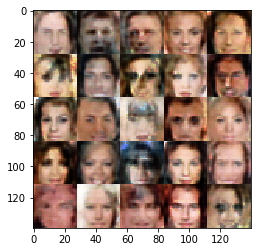

Epoch 0 , batch 1310, dloss = 0.8090 gloss = 1.5111
Epoch 0 , batch 1320, dloss = 0.7727 gloss = 1.3009
Epoch 0 , batch 1330, dloss = 0.9305 gloss = 0.9635
Epoch 0 , batch 1340, dloss = 0.7917 gloss = 1.3383
Epoch 0 , batch 1350, dloss = 0.8702 gloss = 0.9533
Epoch 0 , batch 1360, dloss = 0.8325 gloss = 1.1449
Epoch 0 , batch 1370, dloss = 0.7042 gloss = 2.1840
Epoch 0 , batch 1380, dloss = 0.8660 gloss = 1.0910
Epoch 0 , batch 1390, dloss = 0.8127 gloss = 1.1775
Epoch 0 , batch 1400, dloss = 0.8433 gloss = 1.2249
-----


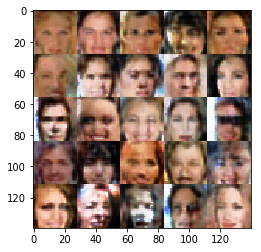

Epoch 0 , batch 1410, dloss = 0.9115 gloss = 0.9886
Epoch 0 , batch 1420, dloss = 0.8367 gloss = 1.0441
Epoch 0 , batch 1430, dloss = 0.7394 gloss = 1.3154
Epoch 0 , batch 1440, dloss = 0.7036 gloss = 2.3564
Epoch 0 , batch 1450, dloss = 1.4727 gloss = 0.4318
Epoch 0 , batch 1460, dloss = 0.8266 gloss = 1.3538
Epoch 0 , batch 1470, dloss = 0.5110 gloss = 2.4600
Epoch 0 , batch 1480, dloss = 0.7823 gloss = 2.2793
Epoch 0 , batch 1490, dloss = 0.9920 gloss = 2.7190
Epoch 0 , batch 1500, dloss = 0.7671 gloss = 1.8029
-----


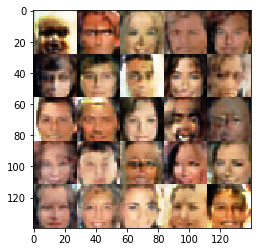

Epoch 0 , batch 1510, dloss = 0.7011 gloss = 1.9571
Epoch 0 , batch 1520, dloss = 0.8425 gloss = 1.1201
Epoch 0 , batch 1530, dloss = 1.0224 gloss = 0.7896
Epoch 0 , batch 1540, dloss = 0.7884 gloss = 1.6644
Epoch 0 , batch 1550, dloss = 0.8133 gloss = 2.2432
Epoch 0 , batch 1560, dloss = 0.8988 gloss = 0.9698
Epoch 0 , batch 1570, dloss = 0.7275 gloss = 1.5786
Epoch 0 , batch 1580, dloss = 0.8618 gloss = 1.1807
Epoch 0 , batch 1590, dloss = 0.8106 gloss = 1.6775
Epoch 0 , batch 1600, dloss = 0.7945 gloss = 1.3734
-----


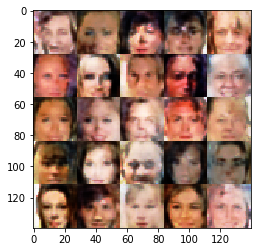

Epoch 0 , batch 1610, dloss = 0.8207 gloss = 1.5574
Epoch 0 , batch 1620, dloss = 0.7066 gloss = 1.5895
Epoch 0 , batch 1630, dloss = 0.7707 gloss = 1.8330
Epoch 0 , batch 1640, dloss = 0.7121 gloss = 1.3629
Epoch 0 , batch 1650, dloss = 0.7886 gloss = 2.0696
Epoch 0 , batch 1660, dloss = 0.9228 gloss = 1.0663
Epoch 0 , batch 1670, dloss = 1.0714 gloss = 2.3911
Epoch 0 , batch 1680, dloss = 0.8785 gloss = 1.7100
Epoch 0 , batch 1690, dloss = 0.9695 gloss = 2.5883
Epoch 0 , batch 1700, dloss = 0.8451 gloss = 1.1585
-----


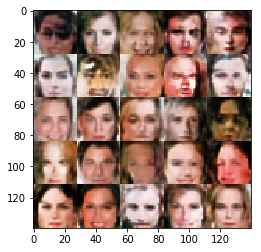

Epoch 0 , batch 1710, dloss = 0.7742 gloss = 1.2933
Epoch 0 , batch 1720, dloss = 0.8944 gloss = 1.1617
Epoch 0 , batch 1730, dloss = 0.7410 gloss = 1.4156
Epoch 0 , batch 1740, dloss = 0.7422 gloss = 1.8891
Epoch 0 , batch 1750, dloss = 0.8473 gloss = 1.8313
Epoch 0 , batch 1760, dloss = 0.9069 gloss = 1.0393
Epoch 0 , batch 1770, dloss = 0.7679 gloss = 1.9924
Epoch 0 , batch 1780, dloss = 0.8802 gloss = 2.2832
Epoch 0 , batch 1790, dloss = 0.9873 gloss = 0.8165
Epoch 0 , batch 1800, dloss = 0.7499 gloss = 1.4716
-----


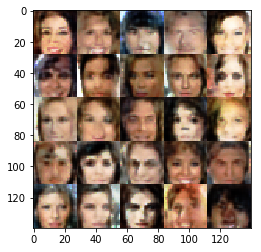

Epoch 0 , batch 1810, dloss = 0.9164 gloss = 1.0810
Epoch 0 , batch 1820, dloss = 0.8241 gloss = 2.3743
Epoch 0 , batch 1830, dloss = 0.6570 gloss = 1.6185
Epoch 0 , batch 1840, dloss = 0.8439 gloss = 2.4307
Epoch 0 , batch 1850, dloss = 1.0161 gloss = 2.7032
Epoch 0 , batch 1860, dloss = 0.8460 gloss = 1.1239
Epoch 0 , batch 1870, dloss = 0.7523 gloss = 1.4574
Epoch 0 , batch 1880, dloss = 0.9437 gloss = 1.9046
Epoch 0 , batch 1890, dloss = 0.7840 gloss = 1.7031
Epoch 0 , batch 1900, dloss = 0.7796 gloss = 1.7310
-----


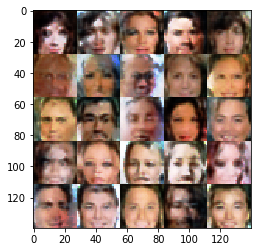

Epoch 0 , batch 1910, dloss = 0.9233 gloss = 2.0318
Epoch 0 , batch 1920, dloss = 0.8180 gloss = 1.6513
Epoch 0 , batch 1930, dloss = 0.8097 gloss = 1.1215
Epoch 0 , batch 1940, dloss = 0.8212 gloss = 1.1891
Epoch 0 , batch 1950, dloss = 0.7779 gloss = 1.7873
Epoch 0 , batch 1960, dloss = 0.8230 gloss = 2.1943
Epoch 0 , batch 1970, dloss = 0.8211 gloss = 1.2741
Epoch 0 , batch 1980, dloss = 0.8693 gloss = 2.5563
Epoch 0 , batch 1990, dloss = 0.7319 gloss = 1.5887
Epoch 0 , batch 2000, dloss = 0.7107 gloss = 2.1796
-----


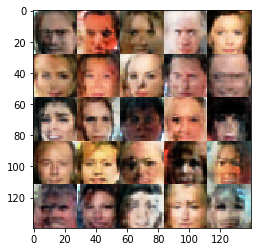

Epoch 0 , batch 2010, dloss = 0.7099 gloss = 1.7360
Epoch 0 , batch 2020, dloss = 0.8751 gloss = 1.4055
Epoch 0 , batch 2030, dloss = 0.7984 gloss = 1.2889
Epoch 0 , batch 2040, dloss = 0.7336 gloss = 1.5756
Epoch 0 , batch 2050, dloss = 0.7191 gloss = 1.5926
Epoch 0 , batch 2060, dloss = 0.9794 gloss = 2.2205
Epoch 0 , batch 2070, dloss = 0.7744 gloss = 1.3646
Epoch 0 , batch 2080, dloss = 0.9845 gloss = 0.8830
Epoch 0 , batch 2090, dloss = 0.8361 gloss = 1.9961
Epoch 0 , batch 2100, dloss = 0.9625 gloss = 0.9070
-----


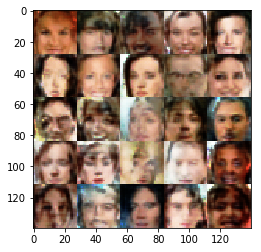

Epoch 0 , batch 2110, dloss = 0.8232 gloss = 1.1596
Epoch 0 , batch 2120, dloss = 0.8252 gloss = 2.0778
Epoch 0 , batch 2130, dloss = 0.6668 gloss = 1.6063
Epoch 0 , batch 2140, dloss = 0.8115 gloss = 2.0194
Epoch 0 , batch 2150, dloss = 0.5811 gloss = 2.3659
Epoch 0 , batch 2160, dloss = 0.7025 gloss = 1.9092
Epoch 0 , batch 2170, dloss = 0.8396 gloss = 1.8044
Epoch 0 , batch 2180, dloss = 0.7119 gloss = 1.6837
Epoch 0 , batch 2190, dloss = 0.6990 gloss = 1.4063
Epoch 0 , batch 2200, dloss = 0.9246 gloss = 1.5456
-----


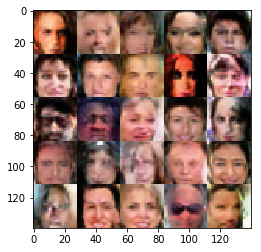

Epoch 0 , batch 2210, dloss = 0.7484 gloss = 1.5628
Epoch 0 , batch 2220, dloss = 0.5995 gloss = 1.6666
Epoch 0 , batch 2230, dloss = 0.7680 gloss = 1.2727
Epoch 0 , batch 2240, dloss = 0.7770 gloss = 1.2598
Epoch 0 , batch 2250, dloss = 0.6047 gloss = 2.3213
Epoch 0 , batch 2260, dloss = 0.5694 gloss = 2.4031
Epoch 0 , batch 2270, dloss = 0.7317 gloss = 1.4349
Epoch 0 , batch 2280, dloss = 0.7890 gloss = 1.7944
Epoch 0 , batch 2290, dloss = 0.7998 gloss = 1.2368
Epoch 0 , batch 2300, dloss = 0.8942 gloss = 1.4874
-----


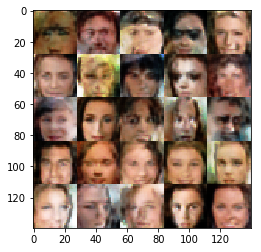

Epoch 0 , batch 2310, dloss = 0.6380 gloss = 1.6403
Epoch 0 , batch 2320, dloss = 0.9184 gloss = 2.9604
Epoch 0 , batch 2330, dloss = 0.7574 gloss = 1.6280
Epoch 0 , batch 2340, dloss = 0.8200 gloss = 1.6465
Epoch 0 , batch 2350, dloss = 0.7572 gloss = 2.1019
Epoch 0 , batch 2360, dloss = 0.7471 gloss = 1.3364
Epoch 0 , batch 2370, dloss = 0.7310 gloss = 1.4056
Epoch 0 , batch 2380, dloss = 0.7627 gloss = 1.6547
Epoch 0 , batch 2390, dloss = 0.5493 gloss = 2.3280
Epoch 0 , batch 2400, dloss = 0.7686 gloss = 1.2947
-----


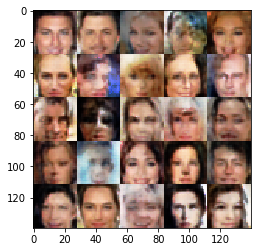

Epoch 0 , batch 2410, dloss = 0.6486 gloss = 1.4803
Epoch 0 , batch 2420, dloss = 0.7418 gloss = 1.5786
Epoch 0 , batch 2430, dloss = 0.7020 gloss = 2.4609
Epoch 0 , batch 2440, dloss = 0.9348 gloss = 2.4909
Epoch 0 , batch 2450, dloss = 0.8722 gloss = 0.9918
Epoch 0 , batch 2460, dloss = 0.8336 gloss = 2.1841
Epoch 0 , batch 2470, dloss = 0.9223 gloss = 3.1597
Epoch 0 , batch 2480, dloss = 1.4865 gloss = 0.4409
Epoch 0 , batch 2490, dloss = 0.6982 gloss = 2.0440
Epoch 0 , batch 2500, dloss = 0.8600 gloss = 1.0919
-----


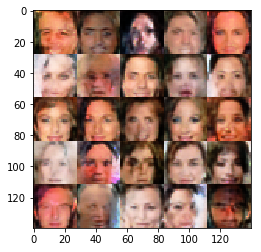

Epoch 0 , batch 2510, dloss = 0.7654 gloss = 1.2407
Epoch 0 , batch 2520, dloss = 0.6053 gloss = 2.1390
Epoch 0 , batch 2530, dloss = 0.7267 gloss = 1.3276
Epoch 0 , batch 2540, dloss = 1.0987 gloss = 0.7344
Epoch 0 , batch 2550, dloss = 0.9915 gloss = 0.8479
Epoch 0 , batch 2560, dloss = 0.7963 gloss = 1.2783
Epoch 0 , batch 2570, dloss = 0.9808 gloss = 2.7420
Epoch 0 , batch 2580, dloss = 0.6752 gloss = 1.6761
Epoch 0 , batch 2590, dloss = 0.9688 gloss = 0.8582
Epoch 0 , batch 2600, dloss = 0.8508 gloss = 1.3723
-----


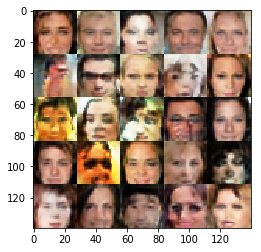

Epoch 0 , batch 2610, dloss = 0.7430 gloss = 1.8096
Epoch 0 , batch 2620, dloss = 0.7167 gloss = 1.4910
Epoch 0 , batch 2630, dloss = 0.8913 gloss = 1.0029
Epoch 0 , batch 2640, dloss = 1.1784 gloss = 3.2260
Epoch 0 , batch 2650, dloss = 0.8119 gloss = 2.0957
Epoch 0 , batch 2660, dloss = 0.7880 gloss = 1.2048
Epoch 0 , batch 2670, dloss = 0.7451 gloss = 1.8621
Epoch 0 , batch 2680, dloss = 0.7097 gloss = 1.7153
Epoch 0 , batch 2690, dloss = 0.7298 gloss = 1.5591
Epoch 0 , batch 2700, dloss = 0.7447 gloss = 1.5482
-----


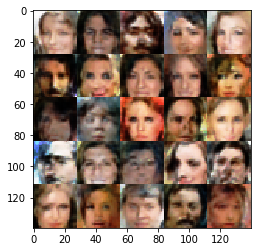

Epoch 0 , batch 2710, dloss = 0.5943 gloss = 1.6314
Epoch 0 , batch 2720, dloss = 0.6370 gloss = 1.8203
Epoch 0 , batch 2730, dloss = 0.8471 gloss = 1.0726
Epoch 0 , batch 2740, dloss = 0.7814 gloss = 2.1885
Epoch 0 , batch 2750, dloss = 0.6206 gloss = 1.6137
Epoch 0 , batch 2760, dloss = 0.6769 gloss = 1.5451
Epoch 0 , batch 2770, dloss = 0.7750 gloss = 1.6494
Epoch 0 , batch 2780, dloss = 0.6888 gloss = 1.5657
Epoch 0 , batch 2790, dloss = 0.6844 gloss = 1.8398
Epoch 0 , batch 2800, dloss = 0.8429 gloss = 1.0227
-----


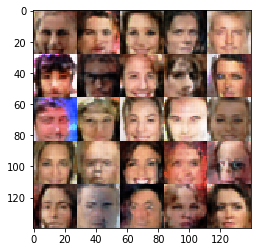

Epoch 0 , batch 2810, dloss = 0.7687 gloss = 3.0158
Epoch 0 , batch 2820, dloss = 0.8489 gloss = 1.2458
Epoch 0 , batch 2830, dloss = 0.6598 gloss = 2.1232
Epoch 0 , batch 2840, dloss = 0.7368 gloss = 1.7207
Epoch 0 , batch 2850, dloss = 0.9230 gloss = 0.8615
Epoch 0 , batch 2860, dloss = 0.7588 gloss = 1.3696
Epoch 0 , batch 2870, dloss = 0.8397 gloss = 1.0591
Epoch 0 , batch 2880, dloss = 1.1311 gloss = 2.8698
Epoch 0 , batch 2890, dloss = 0.7868 gloss = 1.6773
Epoch 0 , batch 2900, dloss = 0.7947 gloss = 2.1245
-----


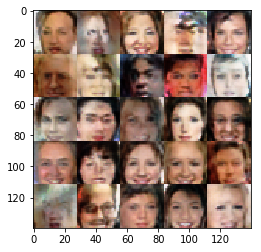

Epoch 0 , batch 2910, dloss = 0.7349 gloss = 1.3500
Epoch 0 , batch 2920, dloss = 0.6682 gloss = 1.5303
Epoch 0 , batch 2930, dloss = 0.7291 gloss = 1.7035
Epoch 0 , batch 2940, dloss = 0.7782 gloss = 1.1744
Epoch 0 , batch 2950, dloss = 0.6873 gloss = 1.5442
Epoch 0 , batch 2960, dloss = 1.2069 gloss = 2.9276
Epoch 0 , batch 2970, dloss = 0.6945 gloss = 2.3001
Epoch 0 , batch 2980, dloss = 1.0655 gloss = 0.7659
Epoch 0 , batch 2990, dloss = 0.7192 gloss = 1.9737
Epoch 0 , batch 3000, dloss = 0.8185 gloss = 2.1459
-----


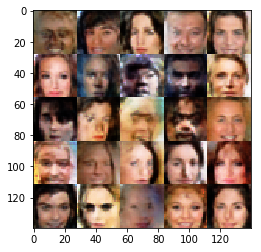

Epoch 0 , batch 3010, dloss = 0.6962 gloss = 1.8462
Epoch 0 , batch 3020, dloss = 0.7645 gloss = 1.2882
Epoch 0 , batch 3030, dloss = 0.8060 gloss = 1.6398
Epoch 0 , batch 3040, dloss = 0.7835 gloss = 1.1993
Epoch 0 , batch 3050, dloss = 0.8122 gloss = 1.5642
Epoch 0 , batch 3060, dloss = 0.7983 gloss = 1.2260
Epoch 0 , batch 3070, dloss = 0.7850 gloss = 1.2180
Epoch 0 , batch 3080, dloss = 0.7277 gloss = 1.5427
Epoch 0 , batch 3090, dloss = 0.7356 gloss = 2.1080
Epoch 0 , batch 3100, dloss = 0.6427 gloss = 2.7540
-----


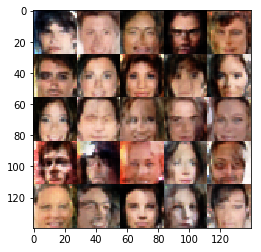

Epoch 0 , batch 3110, dloss = 0.7135 gloss = 1.8049
Epoch 0 , batch 3120, dloss = 0.9110 gloss = 2.5903
Epoch 0 , batch 3130, dloss = 0.7226 gloss = 1.9112
Epoch 0 , batch 3140, dloss = 0.7389 gloss = 1.7360
Epoch 0 , batch 3150, dloss = 0.7340 gloss = 2.2005
Epoch 0 , batch 3160, dloss = 1.0374 gloss = 0.8121
Epoch 0 , batch 3170, dloss = 0.5971 gloss = 1.8363
Epoch 0 , batch 3180, dloss = 0.7524 gloss = 1.6659
Epoch 0 , batch 3190, dloss = 0.6471 gloss = 1.7330
Epoch 0 , batch 3200, dloss = 0.6089 gloss = 1.7944
-----


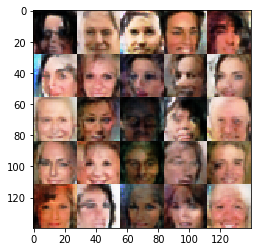

Epoch 0 , batch 3210, dloss = 0.7987 gloss = 1.8614


KeyboardInterrupt: 

In [21]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)
print("DONE")    

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.